In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Download daily stock data for the last 5 years
df = yf.download("TSLA", period="5y", interval="1d")

# Show first 5 rows
print(df.head())

# Check dataset size
print("Dataset shape:", df.shape)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-03-23  28.952667  29.466667  27.366667  28.906668  246817500
2020-03-24  33.666668  34.245998  31.600000  31.820000  343428000
2020-03-25  35.950001  37.133331  34.074001  36.349998  318340500
2020-03-26  35.210667  37.333332  34.150002  36.492668  260710500
2020-03-27  34.290668  35.053333  32.935333  33.666668  215661000
Dataset shape: (1257, 5)


In [3]:
df.to_csv("stock_data_tesla.csv")
print("Dataset saved successfully!")

Dataset saved successfully!


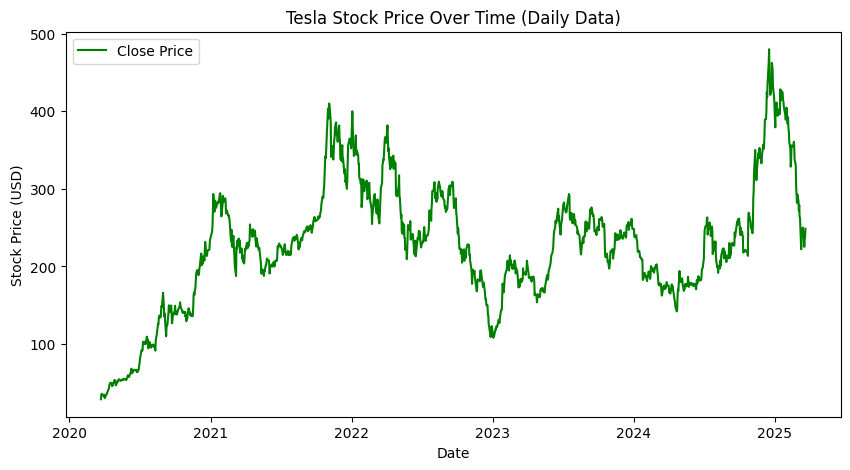

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label="Close Price", color='green')
plt.title("Tesla Stock Price Over Time (Daily Data)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [5]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values using forward fill
df.fillna(method="ffill", inplace=True)


Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7928\2724376878.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the 'Close' price (since we're predicting it)
df_scaled = scaler.fit_transform(df[['Close']])

print("Scaled Data Sample:", df_scaled[:5])  # First 5 values after scaling


Scaled Data Sample: [[0.        ]
 [0.01045448]
 [0.01551834]
 [0.01387868]
 [0.01183836]]


In [7]:
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]

print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (1005, 1)
Test Data Shape: (252, 1)


In [8]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # Last 60 days
        y.append(data[i + time_steps])  # Next day's price
    return np.array(X), np.array(y)

time_steps = 60  # Use last 60 days to predict next price
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)


X_train Shape: (945, 60, 1)
X_test Shape: (192, 60, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50),
    Dropout(0.2),
    
    Dense(units=1)  # Output layer (predict next price)
])

# Print model summary
model.summary()

C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0816 - mse: 0.0816 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.00

In [12]:
# Predict stock prices on the test data
predicted_prices = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [13]:
# Reshape predictions and test labels
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

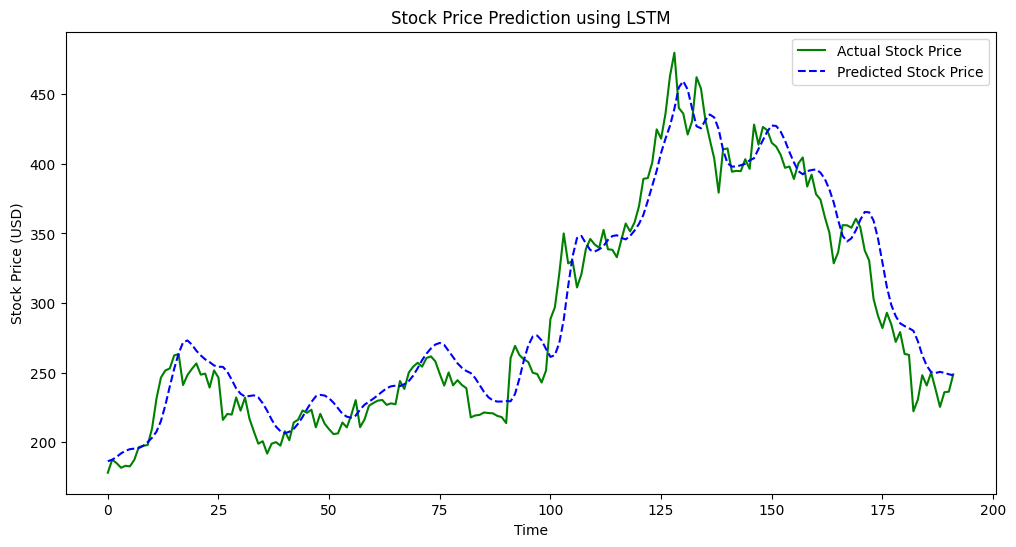

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='green', label="Actual Stock Price")
plt.plot(predicted_prices, color='blue', linestyle='dashed', label="Predicted Stock Price")
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [15]:
# Get the last 60 days of data
last_60_days = df_scaled[-60:]  # Last 60 days (already scaled)

# Reshape to match LSTM input shape
X_future = np.array([last_60_days])
print("Future Input Shape:", X_future.shape)  # Should be (1, 60, 1)

Future Input Shape: (1, 60, 1)


In [16]:
future_predictions = []

# Generate predictions for the next 7 days
for _ in range(7):
    predicted_price = model.predict(X_future)[0]  # Predict next price
    future_predictions.append(predicted_price)  # Store prediction

    # Add the predicted price to the sequence
    new_sequence = np.append(X_future[:, 1:, :], [[predicted_price]], axis=1)
    X_future = new_sequence.reshape(1, 60, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [18]:
# Convert back to actual stock prices
future_predictions = scaler.inverse_transform(future_predictions)

print("Predicted Prices for the Next 7 Days:", future_predictions.flatten())

Predicted Prices for the Next 7 Days: [112436.09415358 113774.87303825 115588.24296305 117624.79622605
 119724.18475138 121802.40197424 123822.83741682]


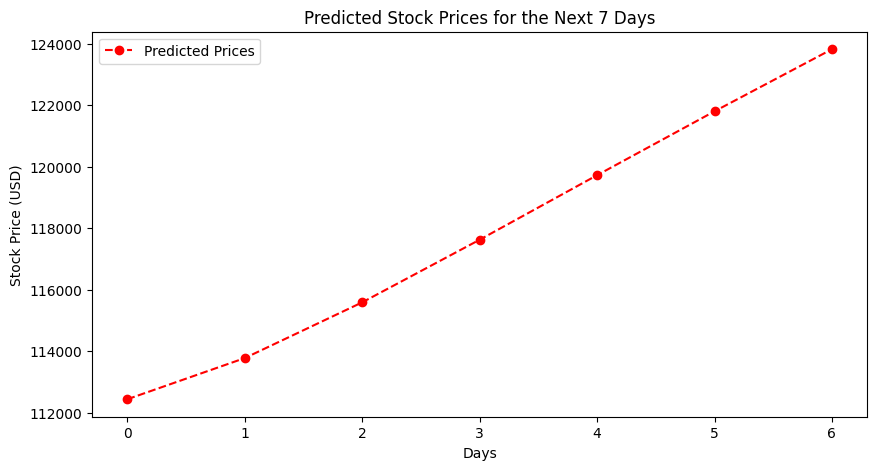

In [19]:
# Plot the next 7 days of predicted prices
plt.figure(figsize=(10, 5))
plt.plot(future_predictions, marker='o', linestyle='dashed', color='red', label="Predicted Prices")
plt.title("Predicted Stock Prices for the Next 7 Days")
plt.xlabel("Days")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [20]:
import nbformat
from nbconvert import PythonExporter

def convert_ipynb_to_py(ipynb_path, py_path):
    with open(ipynb_path, "r", encoding="utf-8") as f:
        notebook = nbformat.read(f, as_version=4)

    exporter = PythonExporter()
    python_script, _ = exporter.from_notebook_node(notebook)

    with open(py_path, "w", encoding="utf-8") as f:
        f.write(python_script)

# Example usage
convert_ipynb_to_py("StockPricePred.ipynb", "app.py")
